# 机器学习纳米学位毕业项目 -- 猫狗大战

苗沛

2018.08.15

**实验环境**

- MacBook 10.13.6
- python 3.5.4
- numpy 1.13.0
- tensorflow 1.3.0
- Keras 1.2.2
- h5py 2.7.1

## 相关软件包导入

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50  
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
import random
import cv2

%matplotlib inline

/Users/miclaelmiao/anaconda2/envs/cat_vs_dog/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/miclaelmiao/anaconda2/envs/cat_vs_dog/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


## 数据预处理

从 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 下载训练数据到`image目录` 并解压到当前目录。

数据集的文件名是以type.num.jpg方式命名的，比如cat.0.jpg。使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中。对数据集进行预处理参考的是[杨培文的Blog](http://www.zhiding.cn/techwalker/documents/J9UpWRDfVYHE5WsOEHbyx4eM8fBcpHYEW_b72QCUihQ)创建符号链接(symbol link)的方法，这样的好处是不用复制一遍图片，占用不必要的空间。

In [2]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)

图像文件分类后的路径如下：

``` python 
├── test [12500 images]
├── test2
│   └── test -> ../test/
├── train [25000 images]
└── train2
    ├── cat [12500 images]
    └── dog [12500 images]

``` 

可视化数据集：

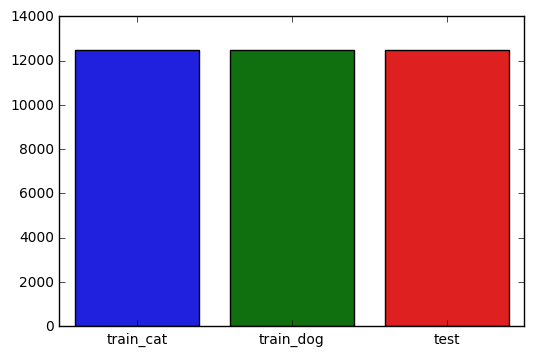

In [3]:
x = ['train_cat', 'train_dog', 'test']
y = [len(os.listdir('train2/cat')), len(os.listdir('train2/dog')), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)

In [4]:
s_count = """image数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(os.listdir('train2/cat')), len(os.listdir('train2/dog')),len(os.listdir('test')))
s_count

'image数据集中，猫的数量：12500，狗的数量：12500，测试集图片数量：12500'

## 导出特征向量

对于这个题目来说，使用预训练的网络是最好不过的了，经过前期的测试，我们测试了 ResNet50 等不同的网络，但是排名都不高，现在看来只有一两百名的样子，所以我们需要提高我们的模型表现。那么一种有效的方法是综合各个不同的模型，从而得到不错的效果，兼听则明。如果是直接在一个巨大的网络后面加我们的全连接，那么训练10代就需要跑十次巨大的网络，而且我们的卷积层都是不可训练的，那么这个计算就是浪费的。所以我们可以将多个不同的网络输出的特征向量先保存下来，以便后续的训练，这样做的好处是我们一旦保存了特征向量，即使是在普通笔记本上也能轻松训练。

经典的CNN输入图像的尺寸，是224×224、227×227、256×256和299×299，但也可以是其他尺寸。

VGG16，VGG19和ResNet均接受224×224输入图像，而Inception V3和Xception需要299×299像素输入

In [8]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    print("func_name=%s".format(MODEL.func_name))

#     gen = ImageDataGenerator()
#     train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
#                                               batch_size=16)
#     test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
#                                              batch_size=16, class_mode=None)

#     train = model.predict_generator(train_generator, train_generator.nb_sample)
#     test = model.predict_generator(test_generator, test_generator.nb_sample)
#     print("func_name=%s".format(MODEL.func_name))
#     with h5py.File("gap_%s.h5"%MODEL) as h:
#         h.create_dataset("train", data=train)
#         h.create_dataset("test", data=test)
#         h.create_dataset("label", data=train_generator.classes)

In [6]:
write_gap(ResNet50, (224, 224))

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
func_name=%s


In [7]:
MODEL

NameError: name 'MODEL' is not defined

In [9]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 60] Operation timed out

In [ ]:
write_gap(Xception, (299, 299), xception.preprocess_input)